In [26]:
import sys
sys.path.insert(0, '../')

In [27]:
from phasor import QWR029, QWR041, QWR053, QWR085
from phasor.torch_helper import run_torch_optimizer, run_torch_optimizer_multi_kwargs, run_torch_LBFGS_multi_kwargs, Standardizer
from phasor import _beam_frequency as _ref_frequency
_ref_wavelength = 299792458 / _ref_frequency
import numpy as np
import torch
import torch.profiler
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import json
from IPython.display import display
from typing import Optional, List, Any
from dataclasses import dataclass
from collections import namedtuple
from scipy.optimize import minimize

In [28]:
tunfile = "C:/Users/HWANG/Workspace/IPSilon/data/velocity_profiles/5kW/20230119_LS1CB_124Xe26+_16p9MeVu.tun"

# cyclic

In [29]:
def wrap(phases, period):
    phases = torch.as_tensor(phases, dtype=torch.float64)
    return  (phases + period / 2) % period - period / 2

def cyclic_difference(x, y, period):
    x = torch.as_tensor(x, dtype=torch.float64)
    y = torch.as_tensor(y, dtype=torch.float64)
    return  (x - y + period / 2) % period - period / 2

def cyclic_distance(x, y, period):
    return torch.abs(cyclic_difference(x, y, period))

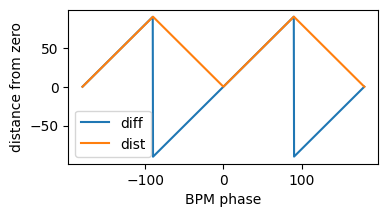

In [30]:
x = torch.linspace(-180,180,1024)
y = torch.zeros(1024)*90
period = 180
diff = cyclic_difference(x,y,180)
dist = torch.abs(diff)
plt.figure(figsize=(4,2))
plt.plot(x,diff,label='diff')
plt.plot(x,dist,label='dist')
plt.legend()
plt.xlabel('BPM phase');
plt.ylabel('distance from zero');

# file reader

In [35]:
def read_tunfile(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    for line in lines:
        if line.startswith("# Beam A:"):
            A = float(line.split(":")[1].strip())
        elif line.startswith("# Beam Q:"):
            Q = float(line.split(":")[1].strip())
        elif line.startswith("# Beam Q stripped:"):
            Qstrip = float(line.split(":")[1].strip())
        elif line.startswith("# Beam init energy (eV/u):"):
            Wu0 = float(line.split(":")[1].strip())
        elif line.startswith("# Beam init phase (deg):"):
            tau0 = float(line.split(":")[1].strip())/180*np.pi
        elif line.startswith("N\t"):
            # Read the dataframe from this line onwards using pandas read_csv
            dataframe = pd.read_csv(filename, skiprows=lines.index(line), delimiter='\t', index_col='N')
            break
    return A, Q, Qstrip, tau0, Wu0, dataframe

In [38]:
A, Q, Qstrip, tau0, Wu0, dataframe = read_tunfile(tunfile)
dataframe[:3]

,z(mm),Name,offset(deg),scale,LOLO,LO,HI,HIHI,phase(deg),field(MV/m),Sync.phase(deg)
N,,,,,,,,,,,
0,0.000000,LS1_WA03:BPM_D1222,-14.768,0.000000,0.0,0.0,0.0,0.0,5.390,0.000,0.000
1,679.809732,LS1_CB01:RFC_D1229,-35.714,0.998897,0.0,0.5,5.6,6.1,166.000,2.605,-31.961
2,928.692620,LS1_CB01:BPM_D1231,-24.822,0.000000,0.0,0.0,0.0,0.0,-46.519,0.000,0.000


# elements map

In [4]:
def Wu2beta(w_u):  
    gamma = 1.+w_u/931.5e6
    return torch.sqrt(1.0 - 1.0 / gamma ** 2)

class drift_map:
    def __init__(self, name, 
                 zc, 
                 # distance,
                 phase,
                 offset,
                 ref_frequency=_ref_frequency):
        self.name = name
        # self.distance = distance
        self.zc = zc
        self.ref_wavelength = 299792458 / ref_frequency
        if isinstance(offset, torch.Tensor):
            self.offset = offset.to(dtype=torch.float64)
        else:
            self.offset = torch.tensor(offset,dtype=torch.float64)
        if isinstance(phase, torch.Tensor):
            self.phase = phase.to(dtype=torch.float64)
        else:
            self.phase = torch.tensor(phase,dtype=torch.float64)
    
    def __call__(self, z, tau, Wu):
        tau = tau.double()
        Wu  = Wu.double()
        distance = self.zc-z
        return z +distance, tau + 2.0 * torch.pi * distance / (Wu2beta(Wu) * self.ref_wavelength),   Wu
        # return tau + 2.0 * torch.pi * self.distance / (Wu2beta(Wu) * self.ref_wavelength),   Wu

class cav_map:
    def __init__(self, name, 
                 zc,
                 # distance,
                 model, QA, scale, 
                 amplitude, phase,
                 offset,
                 ref_frequency=_ref_frequency,
                 is_on = True):        
        self.name = name
        # self.distance = distance
        self.zc = zc
        self.length = model.cav_length
        self.frequency = model.cav_frequency
        self.ref_wavelength = 299792458 / ref_frequency
        self.ref_frequency  = ref_frequency
        self.model = model
        self.is_on = is_on
        if isinstance(QA,torch.Tensor):
            self.QA = QA.to(dtype=torch.float32)
        else:
            self.QA = torch.tensor(QA,dtype=torch.float32)
        if isinstance(amplitude, torch.Tensor):
            self.amplitude = amplitude.to(dtype=torch.float64)
        else:
            self.amplitude = torch.tensor(amplitude,dtype=torch.float64)
        if isinstance(scale, torch.Tensor):
            self.scale = scale.to(dtype=torch.float64)
        else:
            self.scale = torch.tensor(scale,dtype=torch.float64)
        if isinstance(offset, torch.Tensor):
            self.offset = offset.to(dtype=torch.float64)
        else:
            self.offset = torch.tensor(offset,dtype=torch.float64)
        if isinstance(phase, torch.Tensor):
            self.phase = phase.to(dtype=torch.float64)
        else:
            self.phase = torch.tensor(phase,dtype=torch.float64)

    def __call__(self, z, 
                 tau, Wu, amplitude=None, phase = None):
        if not self.is_on:
            distance = self.zc -z +0.5*self.length
            return z+distance, tau + 2.0*torch.pi*distance / (Wu2beta(Wu) * self.ref_wavelength),   Wu
        if phase is None:
            phase = self.phase
        if amplitude is None:
            amplitude = self.amplitude

        tau = tau.double()
        Wu  = Wu.double()
        distance = self.zc -z -0.5*self.length
        # distance = self.distance -0.5*self.length
        tau = tau + 2.0*np.pi*distance / (Wu2beta(Wu) * self.ref_wavelength)
        phase = self.frequency / self.ref_frequency * tau + phase + self.offset
        dTau, dWu_out = self.model(phase, Wu, amplitude*self.scale, self.QA)
        Wu  = Wu  + dWu_out.double()
        tau = tau + dTau.double() + 2.0*np.pi*self.length/(Wu2beta(Wu)*self.ref_wavelength)
        return z + distance + self.length, tau, Wu
        # return tau, Wu

In [ ]:
            offset = offset/180*np.pi
            phase  = phase/180*np.pi
            if 'RFC' in name:
                if 'LS1_CA' in name:
                    model = QWR041
                elif 'LS1_CB' in name or 'FS1_CH' in name:
                    model = QWR085
                elif 'LS2_CC' in name:
                    model = QWR029
                elif 'LS2_CD' in name or 'FS2_CG' in name or 'LS3_CD' in name:
                    model = QWR053
                elif 'MEBT:RFC' in name or 'FS1_MGB' in name or 'STRIP' in name:
                    raise NotImplementedError(f"Cavity model for {name} not implemented")
                cavity = cav_map(name, zc, model, self.Q/self.A, scale, amplitude, phase, offset, is_on=is_on)

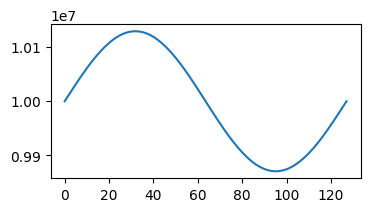

In [48]:
M = cav_map(name='mycav', zc=0, model=QWR085, QA=0.1, scale=1, amplitude=5, phase=0.0, offset=0.0, is_on=True)
with torch.no_grad():
    z, tau, Wu = M(z=0, tau=torch.linspace(-np.pi,np.pi,128), Wu=torch.ones(128)*10e6)
plt.figure(figsize=(4,2))
plt.plot(Wu)

# phasor

In [6]:
@dataclass
class phasor:
    latfile: Optional[str] = None
    vprfile: Optional[str] = None
    tunfile: Optional[str] = None
    A: Optional[float] = None
    Q: Optional[float] = None
    Qstrip: Optional[Any] = None
    Wu_init: Optional[Any] = None  # MeV
    tau_init: Optional[Any] = None  # radian
    l_amplitude: Optional[Any] = None   # 
    l_cav_synch_phase: Optional[Any] = None  # radian
    l_phase: Optional[Any] = None  # radian
    from_element: Optional[str] = None
    to_element: Optional[str] = None
    to_cav: Optional[str] = None
    '''
    l_amplitude: list of cavity amplitudes for list of cavs to over-write amplitude from tunfile if provided
    from_element, to_element defines simulation domain: z=0 at from_element
    to_cav : if not None, all cavities after to_cav will be turned off in simulation
    '''
    
    def __post_init__(self):
        assert self.latfile or self.tunfile
        if self.latfile is not None:
            lattice_df = pd.read_csv(self.latfile, delimiter='\t', index_col='N')
            if self.vprfile is not None:
                vpr_df = pd.read_csv(self.vprfile, delimiter='\t', index_col='N')
                if self.Q and self.A:
                    vpr_df['field(MV/m)'] = vpr_df['E*q/A(MV/m)']*self.A/self.Q
                assert (vpr_df["Name"].values == lattice_df["Name"].values).all()
                lattice_df = pd.concat((lattice_df,vpr_df),axis=1)
        if self.tunfile:
            A, Q, Qstrip, tau_init, Wu_init, _, lattice_df = read_tunfile(self.tunfile)
            self.A = self.A or A
            self.Q = self.Q or Q
            self.Qstrip = self.Qstrip or Qstrip
            self.Wu_init = self.Wu_init or Wu_init
            self.tau_init = self.tau_init or tau_init
            
        i_from_element = 0
        i_to_element = len(lattice_df)
        if self.from_element:
            match = lattice_df.index[lattice_df['Name'] == self.from_element]
            if len(match) == 0:
                raise ValueError(f"from_element '{self.from_element}' not found.")
            i_from_element = match[0]
        if self.to_element:
            i_to_element = lattice_df.index[lattice_df['Name'] == self.to_element][0] + 1
        lattice_df = lattice_df.iloc[i_from_element:i_to_element].reset_index(drop=True)
        assert 'BPM' in lattice_df['Name'][0]
        lattice_df['z(mm)'] -= lattice_df['z(mm)'].loc[0]
        # lattice_df['offset(deg)'] -= lattice_df['offset(deg)'].loc[0]
        self.lattice_df = lattice_df
        
        self.i_cav = [i for i, name in enumerate(self.lattice_df['Name']) if 'RFC' in name]
        self.i_bpm = [i for i, name in enumerate(self.lattice_df['Name']) if 'BPM' in name]
        
        if not self.i_cav:
            raise ValueError("No RF cavities found in lattice!")
        
        if 'field(MV/m)' not in self.lattice_df.columns:
            if self.l_amplitude is None
                raise ValueError('provided file nor l_amplitude input do not contain cavity field amplitude')
            self.lattice_df['field(MV/m)'] = 0.0
        if self.l_amplitude is not None:
            self.lattice_df.loc[self.i_cav, 'field(MV/m)'] = self.l_amplitude

        if 'phase(deg)' not in self.lattice_df.columns:
            if self.l_phase is None
                raise ValueError('provided file nor l_phase input do not contain cavity phase ')
            self.lattice_df['phase(deg)'] = 0.0
        if self.l_phase is not None:
            self.lattice_df.loc[self.i_cav, 'phase(deg)'] = np.array(self.l_phase)/np.pi*180
        
        if 'Sync.phase(deg)' not in self.lattice_df.columns:
            self.lattice_df['Sync.phase(deg)'] = 0.0
        if self.l_cav_synch_phase is not None:
            self.lattice_df.loc[self.i_cav, 'Sync.phase(deg)'] = np.array(self.l_cav_synch_phase)/np.pi*180

        self.lattice_df['is_on'] = '' 
        
        del self.l_amplitude
        del self.l_cav_synch_phase
        del self.l_phase
        
        self.l_map = []
        self.l_cav_map = []
        is_on = True
        for zc, name, scale, amplitude, phase, offset in zip( # self.lattice_df.index,
                                                                self.lattice_df['z(mm)']*1e-3,
                                                                self.lattice_df['Name'],
                                                                self.lattice_df['scale'],
                                                                self.lattice_df['field(MV/m)'],
                                                                self.lattice_df['phase(deg)'],
                                                                self.lattice_df['offset(deg)'],
                                                                ):
            offset = offset/180*np.pi
            phase  = phase/180*np.pi
            if 'RFC' in name:
                if 'LS1_CA' in name:
                    model = QWR041
                elif 'LS1_CB' in name or 'FS1_CH' in name:
                    model = QWR085
                elif 'LS2_CC' in name:
                    model = QWR029
                elif 'LS2_CD' in name or 'FS2_CG' in name or 'LS3_CD' in name:
                    model = QWR053
                elif 'MEBT:RFC' in name or 'FS1_MGB' in name or 'STRIP' in name:
                    raise NotImplementedError(f"Cavity model for {name} not implemented")
                cavity = cav_map(name, zc, model, self.Q/self.A, scale, amplitude, phase, offset, is_on=is_on)
                loc = self.lattice_df.index[self.lattice_df['Name'] == name][0]
                self.lattice_df.loc[loc,'is_on'] = is_on
                self.l_map.append(cavity)
                self.l_cav_map.append(cavity)
                if self.to_cav is not None:
                    if name == self.to_cav:
                        is_on = False
            else:
                self.l_map.append(drift_map(name, zc, phase, offset))

    def update_lattice_from_map(self):
        for M in self.l_map:
            loc = self.lattice_df.index[self.lattice_df['Name'] == M.name][0]
            if isinstance(M, cav_map):
                self.lattice_df.loc[loc,'phase(deg)' ] = wrap(M.phase /np.pi*180,limit=180).item()
                self.lattice_df.loc[loc,'offset(deg)'] = wrap(M.offset/np.pi*180,limit=180).item()
                # self.lattice_df.loc[loc,'Sync.phase(deg)'] = wrap((M.phase-M.offset)/np.pi*180,limit=180).item()
                self.lattice_df.loc[loc,'field(MV/m)'] = M.amplitude.item()
                self.lattice_df.loc[loc,'scale'] = M.scale.item()
                self.lattice_df.loc[loc,'is_on'] = M.is_on
            else:
                self.lattice_df.loc[loc,'phase(deg)' ] = wrap(M.phase /np.pi*180,limit=90).item()
                self.lattice_df.loc[loc,'offset(deg)'] = wrap(M.offset/np.pi*180,limit=90).item()

    def update_map_from_lattice(self):
        for M in self.l_map:
            loc = self.lattice_df.index[self.lattice_df['Name'] == M.name][0]
            M.phase  = torch.tensor(self.lattice_df.loc[loc, 'phase(deg)' ] / 180 * np.pi, dtype=torch.float64)
            M.offset = torch.tensor(self.lattice_df.loc[loc, 'offset(deg)'] / 180 * np.pi, dtype=torch.float64)
            if isinstance(M, cav_map):
                M.amplitude = torch.tensor(self.lattice_df.loc[loc, 'field(MV/m)'], dtype=torch.float64)
                M.scale     = torch.tensor(self.lattice_df.loc[loc, 'scale'      ], dtype=torch.float64)
                M.is_on     = self.lattice_df.loc[loc, 'is_on']

    def set_synch_phase(self, z=0.0, tau=None, Wu=None, l_cav_synch_phase=None):
        if tau is None:
            tau = self.tau_init
        if Wu is None:
            Wu = self.Wu_init
        tau = torch.tensor(tau, dtype=torch.float64)
        Wu  = torch.tensor(Wu, dtype=torch.float64)
        if l_cav_synch_phase is not None:
            assert len(l_cav_synch_phase) == len(self.i_cav)
            self.lattice_df.loc[self.i_cav, 'Sync.phase(deg)'] = np.array(l_cav_synch_phase)/np.pi*180
    
        for i,M in enumerate(self.l_map):
            # print("M.name,tau,Wu",M.name,tau,Wu)
            if isinstance(M, cav_map):
                if M.is_on:
                    synch_phase = self.lattice_df.loc[i,'Sync.phase(deg)']/180*np.pi
                    phase_opt = self.find_maxgain_phase(M, z, tau, Wu)
                    M.phase = wrap(phase_opt + synch_phase, limit=np.pi)
                    # self.lattice_df.loc[i,'phase(deg)'] = M.phase/np.pi*180
                z, tau, Wu = M(z, tau, Wu)
                tau = tau.detach()
                Wu = Wu.detach()
            else:
                z, tau, Wu = M(z, tau, Wu)
                M.phase = wrap(tau + M.offset, limit=np.pi)
                # self.lattice_df.loc[i,'phase(deg)'] = wrap(tau + M.offset, limit=np.pi)
        self.update_lattice_from_map()
    
    def find_maxgain_phase(self, cavity, z, tau, Wu, max_iter=100, lr=0.05, plot_history=True):
        def loss_func(phase):
            phase = phase.view(-1)
            _, tau_out, Wu_out = cavity(z, tau, Wu, phase=phase)
            return {'loss': -(Wu_out - Wu)*1e-6}
        result = run_torch_optimizer(loss_func, 
                                     torch.linspace(-torch.pi,torch.pi,8).view(-1,1), 
                                     max_iter=max_iter, 
                                     lr=lr, 
                                     plot_history=plot_history)
        return result.x[torch.argmin(result.losses['loss'])].item()

    def get_bpm_df(self):
        return self.lattice_df.loc[self.i_bpm]
        
    def get_cav_df(self):
        return self.lattice_df.loc[self.i_cav]

    def _get_lossfunc_phase_offset_err( self,
        loss_func_scaler,
        train_ll_phase,
        train_ll_bpm_phase,
        tau_init = None, 
        Wu_init = None,
        fit_init = False,
        tau_init_tol=2/180*np.pi, 
        Wu_init_tol=0.01, # MeV/u
        fit_training_data = False,
        bpm_phase_tol=2/180*np.pi, 
        batch_size = 16,
        ):
        '''
        tau_init           : scalar  
        Wu_init            : scalar
        train_ll_phase     : (n_scan, n_scan_cav)
        train_ll_bpm_phase : (n_scan, n_monitor)
        bpm_phase_tol      : scalar
        '''
        if tau_init is None:
            tau_init = self.tau_init
        tau_init = tau_init*torch.ones(batch_size, dtype=torch.float64)
        if Wu_init is None:
            Wu_init = self.Wu_init
        Wu_init = Wu_init*torch.ones(batch_size, dtype=torch.float64)

        train_ll_phase = train_ll_phase if isinstance(train_ll_phase, torch.Tensor) else torch.tensor(train_ll_phase, dtype=torch.float64)
        train_ll_bpm_phase = train_ll_bpm_phase if isinstance(train_ll_bpm_phase, torch.Tensor) else torch.tensor(train_ll_bpm_phase, dtype=torch.float64)

        n_scan = train_ll_phase.shape[0]
        assert n_scan == train_ll_bpm_phase.shape[0]  # n_scan
        assert train_ll_phase.shape[1] == len(self.i_cav) # n_scan_cav
        assert train_ll_bpm_phase.shape[1] == len(self.i_bpm)  # n_monitor
        bpm_phase_offset = self.get_bpm_offset()
        train_ll_bpm_phase_sub_offset = train_ll_bpm_phase - bpm_phase_offset.view(1,-1)  # (n_scan,n_monitor)

        train_ll_phase = train_ll_phase.unsqueeze(2)
        train_ll_bpm_phase_sub_offset = train_ll_bpm_phase_sub_offset.unsqueeze(2)
        def loss_func_kernel(train_ll_phase, train_ll_bpm_phase_sub_offset, tau, Wu):
            '''
            tau           : (batch_size,) or scalar  
            Wu            : (batch_size,) or scalar
            train_ll_phase     : (n_scan, n_scan_cav, 1 or batch_size)
            train_ll_bpm_phase_sub_offset : (n_scan, n_monitor, 1 or batch_size)
            '''
            loss = torch.zeros(batch_size)
            for l_phase, l_bpm_phase in zip(train_ll_phase, train_ll_bpm_phase_sub_offset):
                l_tau, l_Wu = self(
                    0.0, tau, Wu,
                    l_phase
                )
                loss = loss + cyclic_distance(l_tau, l_bpm_phase, period=torch.pi, eps=torch.pi)**2  # l_tau is shape of (n_monitor, batch_size)
            return torch.mean(loss/bpm_phase_tol,dim=0)/n_scan
        
        if not fit_training_data and not fit_init:
            def loss_func(offset_err):
                '''
                offset_err : (n_scan_cav, batch_size)
                '''
                inputdic = loss_func_scaler.inverse(offset_err=offset_err)
                loss = loss_func_kernel(
                                    train_ll_phase+inputdic['offset_err'].unsqueeze(0),
                                    train_ll_bpm_phase_sub_offset,
                                    tau_init,
                                    Wu_init,
                                    )
                return {"loss":loss}
                
        elif not fit_training_data and fit_init:
            def loss_func(offset_err,tau_init_err,Wu_init_err):
                '''
                offset_err : (n_scan_cav, batch_size)
                tau_init_err, Wu_init_err : (batch_size)
                '''
                inputdic = loss_func_scaler.inverse(offset_err=offset_err,
                                                    tau_init_err=tau_init_err,
                                                    Wu_init_err=Wu_init_err)
                loss = loss_func_kernel(
                                    train_ll_phase+inputdic['offset_err'].unsqueeze(0),
                                    train_ll_bpm_phase_sub_offset,
                                    tau_init +inputdic['tau_init_err'],
                                    Wu_init  +inputdic['Wu_init_err'],
                                    )
                regloss_init_err = (inputdic['tau_init_err']/tau_init_tol)**2 + (inputdic['Wu_init_err'] /Wu_init_tol )**2
                return {"loss":loss,
                        "regloss_fit_init_err":regloss_tau_err,
                       }
        elif fit_training_data and not fit_init:
            def loss_func(offset_err,bpm_phase_offset_err):
                '''
                offset_err : (n_scan_cav, batch_size)
                bpm_phase_offset_err, (n_monitor, batch_size)
                '''
                inputdic = loss_func_scaler.inverse(
                    offset_err=offset_err,
                    bpm_phase_offset_err=bpm_phase_offset_err
                )
                loss = loss_func_kernel(
                                    train_ll_phase+inputdic['offset_err'].unsqueeze(0),
                                    train_ll_bpm_phase_sub_offset - inputdic['bpm_phase_offset_err'].unsqueeze(0),
                                    tau_init,
                                    Wu_init,
                                    )
                return {"loss":loss}
        else:
            def loss_func(offset_err,bpm_phase_offset_err,tau_init_err,Wu_init_err):
                '''
                offset_err : (n_scan_cav, batch_size)
                bpm_phase_offset_err, (n_monitor, batch_size)
                tau_init_err, Wu_init_err : (batch_size)
                '''
                inputdic = loss_func_scaler.inverse(offset_err=offset_err,
                                                    bpm_phase_offset_err=bpm_phase_offset_err,
                                                    tau_init_err=tau_init_err,
                                                    Wu_init_err=Wu_init_err)
                loss = loss_func_kernel(
                                    train_ll_phase+inputdic['offset_err'].unsqueeze(0),
                                    train_ll_bpm_phase_sub_offset - inputdic['bpm_phase_offset_err'].unsqueeze(0),
                                    tau_init +inputdic['tau_init_err'],
                                    Wu_init  +inputdic['Wu_init_err'],
                                    )
                regloss_init_err = (inputdic['tau_init_err']/tau_init_tol)**2 + (inputdic['Wu_init_err'] /Wu_init_tol )**2
                return {"loss":loss,
                        "regloss_fit_init_err":regloss_tau_err,
                       }
        return loss_func

    def infer_phase_offset_err(self,
        train_ll_phase,
        train_ll_bpm_phase,
        tau_init=None, Wu_init=None,
        fit_init = False,
        tau_init_tol=2/180*np.pi, Wu_init_tol=0.01, # MeV/u
        fit_training_data = False,
        bpm_phase_tol=2/180*np.pi, 
        batch_size = 8,        
        max_iter = 300,
        lr = 0.05,
        plot_history = True,
        ):
        '''
        tau_init           : scalar  
        Wu_init            : scalar
        train_ll_phase     : (n_scan, n_scan_cav)
        train_ll_bpm_phase : (n_scan, n_monitor)
        bpm_phase_tol      : scalar
        '''
        
        standarization_input_info={'offset_err':{'min':-torch.pi,'max': torch.pi}}        
        if fit_init:
            standarization_input_info['tau_init_err'] = {'mean':0,'std':tau_init_tol}
            standarization_input_info[ 'Wu_init_err'] = {'mean':0,'std': Wu_init_tol}            
        if fit_training_data:
            standarization_input_info['bpm_phase_offset_err']={'min':-0.5*torch.pi,'max': 0.5*torch.pi}
        loss_func_scaler = Standardizer(standarization_input_info)

        n_init_factor = 128*len(self.i_cav)
        loss_func = self._get_lossfunc_phase_offset_err(
            loss_func_scaler = loss_func_scaler,
            train_ll_phase = train_ll_phase,
            train_ll_bpm_phase = train_ll_bpm_phase,
            tau_init = tau_init, 
            Wu_init  = Wu_init,
            fit_init = fit_init,
            tau_init_tol = tau_init_tol, 
            Wu_init_tol = Wu_init_tol,
            fit_training_data = fit_training_data,
            bpm_phase_tol = bpm_phase_tol,
            batch_size = batch_size*n_init_factor
        )
        offset_err = 2*torch.pi*torch.rand(len(self.i_cav),batch_size*n_init_factor)-torch.pi  #(n_scan_cav, batch_size)
        # mask = torch.zeros_like(offset_err)
        # n = 16*batch_size
        # for i in range(len(self.i_cav)):
        #     mask[i,i*n:(i+1)*n] = offset_err[i,i*n:(i+1)*n]
        # mask[:,(i+1)*n:] = offset_err[:,(i+1)*n:]
        # offset_err = mask
        # offset_err[:,len(self.i_cav)*n: len(self.i_cav)*n*2]*=0.2
        loss_func_kwargs = loss_func_scaler.transform(offset_err=offset_err)
        if fit_init:
            tau_init_err = torch.randn(batch_size*n_init_factor)
            Wu_init_err  = torch.randn(batch_size*n_init_factor)
            # tau_init_err[:,:batch_size]*=1e-2
            # Wu_init_err [:,:batch_size]*=1e-2
            loss_func_kwargs.update( loss_func_scaler.transform(tau_init_err=tau_init_err,
                                                                Wu_init_err=Wu_init_err)
                                   )
        if fit_training_data:
            bpm_phase_offset_err = torch.pi*torch.rand(len(self.i_bpm),batch_size*n_init_factor)-0.5*torch.pi  #(n_monitor, batch_size)
            # bpm_phase_offset_err[:,:batch_size] *= 1e-2
            loss_func_kwargs.update( loss_func_scaler.transform(bpm_phase_offset_err=bpm_phase_offset_err))

        with torch.no_grad():
            losses = loss_func(**loss_func_kwargs)
            sorted_indices = losses['loss'].argsort()[:batch_size]

        loss_func_kwargs['offset_err'] = loss_func_kwargs['offset_err'][:,sorted_indices]
        if fit_training_data:
            loss_func_kwargs['bpm_phase_offset_err'] = loss_func_kwargs['bpm_phase_offset_err'][:, sorted_indices]
        if fit_init:    
            loss_func_kwargs['tau_init_err'] = loss_func_kwargs['tau_init_err'][sorted_indices]
            loss_func_kwargs['Wu_init_err'] = loss_func_kwargs['Wu_init_err'][sorted_indices]

        loss_func = self._get_lossfunc_phase_offset_err(
            loss_func_scaler = loss_func_scaler,
            train_ll_phase = train_ll_phase,
            train_ll_bpm_phase = train_ll_bpm_phase,
            tau_init = tau_init, 
            Wu_init  = Wu_init,
            fit_init = fit_init,
            tau_init_tol = tau_init_tol, 
            Wu_init_tol = Wu_init_tol,
            fit_training_data = fit_training_data,
            bpm_phase_tol = bpm_phase_tol,
            batch_size = batch_size
        )

        # result = run_torch_LBFGS_multi_kwargs(
        result = run_torch_optimizer_multi_kwargs(
                        loss_func = loss_func,
                        x0_dict = loss_func_kwargs,
                        max_iter = max_iter,
                        lr = lr,
                        loss_weights = {"loss":1.0,
                                        "regloss_fit_init_err":1.0,
                                       },
                        plot_history = plot_history,
                        )
        result.x = loss_func_scaler.inverse(**result.x)
        
        return result

    def get_bpm_offset(self):
        return torch.as_tensor(self.get_bpm_df()['phase(deg)'].values/180*torch.pi,dtype=torch.float64)

    def __call__(self,
                 z,
                 tau, #(batch_size,)
                 Wu,  #(batch_size,)
                 l_phase=None,   # (n_cav, batch_size)
                 i_monitors=None, 
                 report_only_at_BPMs=True):
        
        if i_monitors is None:
            if report_only_at_BPMs:
                i_monitors = self.i_bpm
            else:
                i_monitors = np.arange(len(self.lmap))

        tau = torch.as_tensor(tau)
        Wu  = torch.as_tensor(Wu)
        if tau.ndim == 0:
            batch_size = 1
        else:
            batch_size = tau.shape[0]
            
        l_tau = torch.empty(len(i_monitors),batch_size,dtype=torch.float64)
        l_Wu  = torch.empty(len(i_monitors),batch_size,dtype=torch.float64)
        imon=0
        icav=0
        for iM, M in enumerate(self.l_map):
            if iM in self.i_cav and l_phase is not None:
                z, tau, Wu = M(z, tau, Wu, phase=l_phase[icav,:])
                icav += 1
            else:
                z, tau, Wu = M(z, tau, Wu)
            if iM in i_monitors:
                l_tau[imon] = tau
                l_Wu [imon] = Wu
                imon += 1
        return l_tau, l_Wu  

In [7]:
lat = lattice(tunfile="C:/Users/HWANG/Workspace/IPSilon/data/velocity_profiles/5kW/20230119_LS1CB_124Xe26+_16p9MeVu.tun",
              from_element=None,
              to_cav = 'LS1_CB01:RFC_D1281',
              to_element ='LS1_WB01:BPM_D1286',	
              # to_cav = 'LS1_CB01:RFC_D1249',
              # to_element ='LS1_CB01:BPM_D1251',
              # to_element ='LS1_CB02:BPM_D1315',
             )
n_cav = len(lat.i_cav)
lat.Wu_init

1486000.0

In [8]:
lat.lattice_df

,z(mm),Name,offset(deg),scale,LOLO,LO,HI,HIHI,phase(deg),field(MV/m),Sync.phase(deg),is_on
0,0.000000,LS1_WA03:BPM_D1222,-14.768,0.000000,0.0,0.0,0.0,0.0,5.390,0.000,0.000,
1,679.809732,LS1_CB01:RFC_D1229,-35.714,0.998897,0.0,0.5,5.6,6.1,166.000,2.605,-31.961,True
2,928.692620,LS1_CB01:BPM_D1231,-24.822,0.000000,0.0,0.0,0.0,0.0,-46.519,0.000,0.000,
3,1881.802572,LS1_CB01:RFC_D1241,160.177,1.014748,0.0,0.5,5.6,6.1,149.000,2.186,-24.113,True
4,2279.806572,LS1_CB01:RFC_D1245,-143.889,0.998914,0.0,0.5,5.6,6.1,174.350,2.196,-24.937,True
5,2676.874572,LS1_CB01:RFC_D1249,89.099,0.978616,0.0,0.5,5.6,6.1,44.450,2.270,-25.438,True
6,2926.710880,LS1_CB01:BPM_D1251,-30.597,0.000000,0.0,0.0,0.0,0.0,-79.371,0.000,0.000,
7,3879.892412,LS1_CB01:RFC_D1261,19.330,0.972745,0.0,0.5,5.6,6.1,103.801,2.677,-28.257,True
8,4276.792412,LS1_CB01:RFC_D1265,122.324,1.002423,0.0,0.5,5.6,6.1,143.551,2.600,-28.407,True
9,4675.156412,LS1_CB01:RFC_D1269,164.988,0.974021,0.0,0.5,5.6,6.1,-98.350,2.670,-27.442,True


# Test Synch_phase

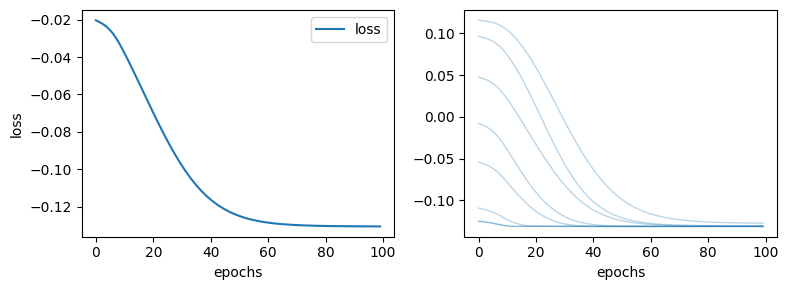

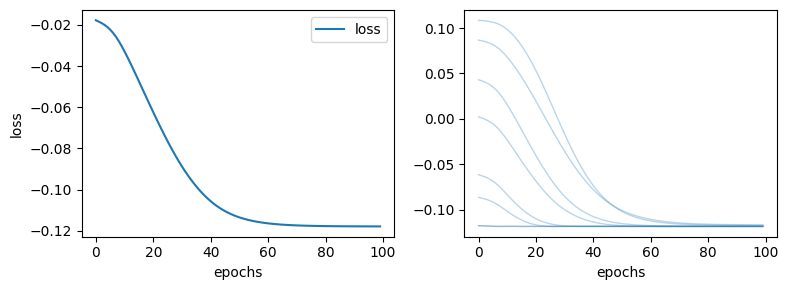

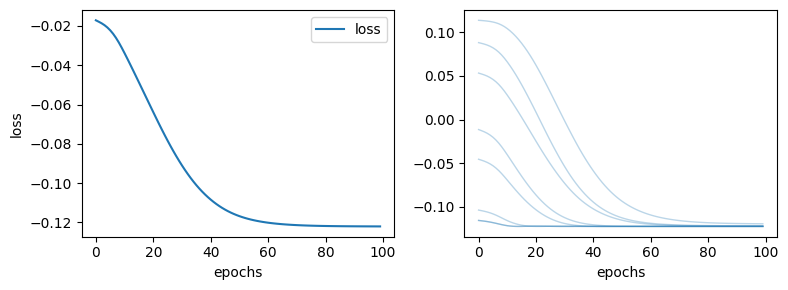

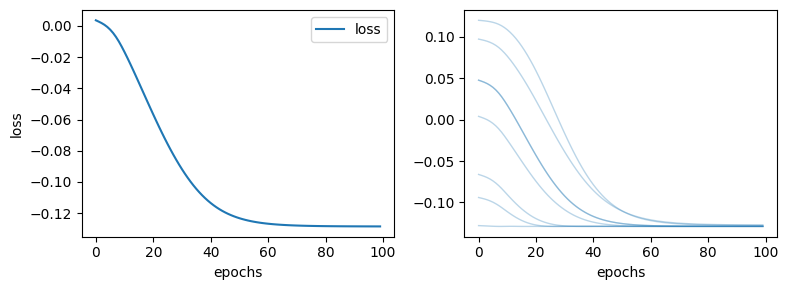

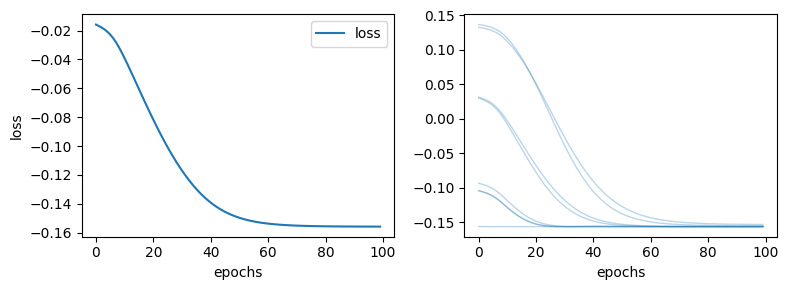

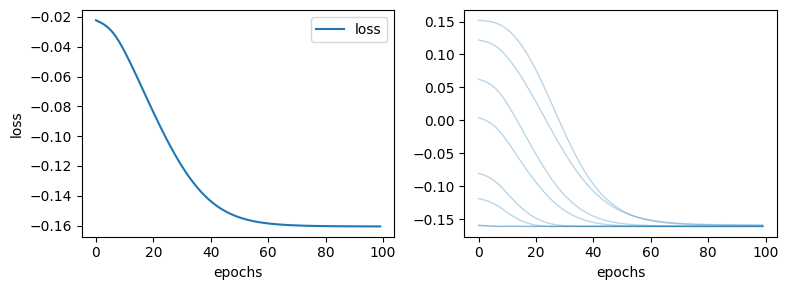

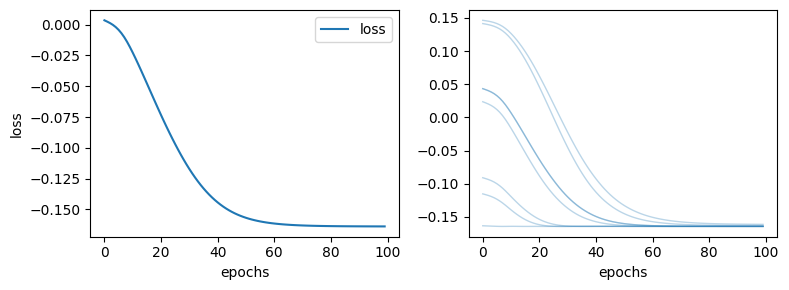

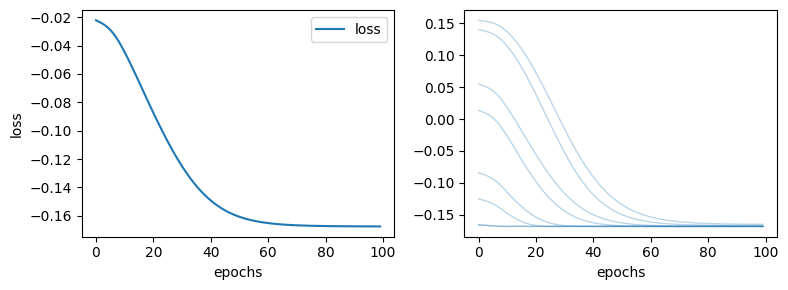

In [9]:
lat.set_synch_phase()

In [10]:
lat.get_cav_df()

,z(mm),Name,offset(deg),scale,LOLO,LO,HI,HIHI,phase(deg),field(MV/m),Sync.phase(deg),is_on
1,679.809732,LS1_CB01:RFC_D1229,-35.714,0.998897,0.0,0.5,5.6,6.1,166.081636,2.605,-31.961,True
3,1881.802572,LS1_CB01:RFC_D1241,160.177,1.014748,0.0,0.5,5.6,6.1,149.208747,2.186,-24.113,True
4,2279.806572,LS1_CB01:RFC_D1245,-143.889,0.998914,0.0,0.5,5.6,6.1,174.361899,2.196,-24.937,True
5,2676.874572,LS1_CB01:RFC_D1249,89.099,0.978616,0.0,0.5,5.6,6.1,44.588091,2.270,-25.438,True
7,3879.892412,LS1_CB01:RFC_D1261,19.330,0.972745,0.0,0.5,5.6,6.1,104.027686,2.677,-28.257,True
8,4276.792412,LS1_CB01:RFC_D1265,122.324,1.002423,0.0,0.5,5.6,6.1,143.573994,2.600,-28.407,True
9,4675.156412,LS1_CB01:RFC_D1269,164.988,0.974021,0.0,0.5,5.6,6.1,-98.294011,2.670,-27.442,True
11,5878.123252,LS1_CB01:RFC_D1281,67.802,0.994930,0.0,0.5,5.6,6.1,152.754055,2.624,-36.875,True


# Test offset fit - zero offset err

In [11]:
l_phase = torch.tensor(lat.get_cav_df()['phase(deg)'].values/180*np.pi,dtype=torch.float64).view(1,-1)

In [12]:
# scan first few cav

# offsets = torch.arange(17)/17*360-180
# m_cav = 2
# n_scan = len(offsets) * m_cav
# ll_offset = torch.zeros((n_scan, n_cav))
# row_idx = 0
# for i_cav in range(m_cav):
#     for offset in offsets:
#         ll_offset[row_idx, i_cav] = offset
#         row_idx += 1

In [13]:
# Sobol random first few cav

n_scan = 64*4
m_cav = 3
ll_offset = torch.zeros((n_scan, n_cav))
ll_offset[:,:m_cav] = torch.quasirandom.SobolEngine(dimension=m_cav).draw(n_scan)*360-180

In [14]:
# n_scan = 32
# with torch.no_grad():
#     l_phase = torch.tensor(lat.get_cav_df()['phase(deg)'].values/180*np.pi,dtype=torch.float64)
#     ll_phase = torch.stack([l_phase.clone()]*n_scan,dim=0)
#     ll_phase[:,0] = ll_phase[0,0]+torch.linspace(-175,175,n_scan)
#     ll_phase = ll_phase/180*torch.pi
#     ll_tau = []
#     for l_phase in ll_phase:
#         l_tau, l_Wu = lat(0.0,lat.tau_init,lat.Wu_init,l_phase=l_phase.unsqueeze(1),i_monitors=lat.i_bpm)
#         ll_tau.append(l_tau.view(-1))
    
# ll_bpm_phase = wrap(torch.stack(ll_tau,dim=0) + lat.get_bpm_offset().view(1,-1), limit=0.5*torch.pi)
# ll_bpm_phase_sub_offset = ll_bpm_phase - lat.get_bpm_offset().view(1,-1)

In [15]:
ll_phase = l_phase.clone() + ll_offset.clone()

with torch.no_grad():
    ll_tau = []
    for l_phase in ll_phase:
        l_tau, l_Wu = lat(0.0,lat.tau_init,lat.Wu_init,l_phase=l_phase.unsqueeze(1),i_monitors=lat.i_bpm)
        ll_tau.append(l_tau.view(-1))
    
ll_bpm_phase = wrap(torch.stack(ll_tau,dim=0) + lat.get_bpm_offset().view(1,-1), limit=0.5*torch.pi)
ll_bpm_phase_sub_offset = ll_bpm_phase - lat.get_bpm_offset().view(1,-1)

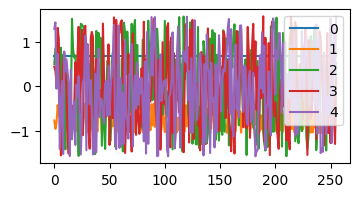

In [16]:
plt.figure(figsize=(4,2))
for ibpm in range(ll_bpm_phase.shape[1]):
    plt.plot(ll_bpm_phase[:,ibpm],label=ibpm)
plt.legend()

In [17]:
ll_tau_test = []
ll_bpm_phase_test = []
lll_phase_test = []
bpm_phase_tol=2/180*np.pi
for i in range(10):
    ll_tau_test.append([])
    with torch.no_grad():
        ll_phase_test = ll_phase.clone()
        ll_phase_test[:,1] += i*3/180*torch.pi
        lll_phase_test.append(ll_phase_test)
        for l_phase in ll_phase_test:
            l_tau, l_Wu = lat(0.0,lat.tau_init,lat.Wu_init,l_phase=l_phase.unsqueeze(1),i_monitors=lat.i_bpm)
            ll_tau_test[-1].append(l_tau.view(-1))
    ll_tau_test[-1] = torch.stack(ll_tau_test[-1],dim=0)
    ll_bpm_phase_test.append(wrap(ll_tau_test[-1] + lat.get_bpm_offset().view(1,-1), limit=0.5*torch.pi))
ll_tau_test = torch.stack(ll_tau_test,dim=0)
ll_bpm_phase_test = torch.stack(ll_bpm_phase_test,dim=0)

In [18]:
ll_phase_test.shape, l_tau.shape

(torch.Size([256, 8]), torch.Size([5, 1]))

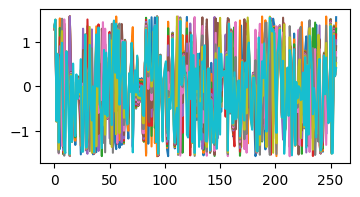

In [19]:
plt.figure(figsize=(4,2))
for i,bpm_phase_test in enumerate(ll_bpm_phase_test):
    plt.plot(bpm_phase_test[:,-1],label=i)

In [20]:
ll_bpm_phase_test.shape

torch.Size([10, 256, 5])

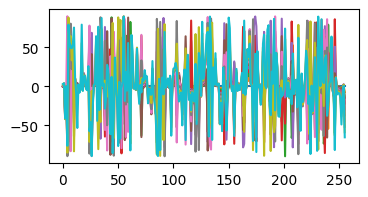

In [21]:
plt.figure(figsize=(4,2))
for i,bpm_phase_test in enumerate(ll_bpm_phase_test):
    plt.plot(wrap(bpm_phase_test[:,-1]-ll_bpm_phase[:,-1], limit=0.5*torch.pi)/np.pi*180,label=i)

In [22]:
ll_tau_test.shape, ll_bpm_phase.shape

(torch.Size([10, 256, 5]), torch.Size([256, 5]))

In [23]:
for ll_phase_test in lll_phase_test:
    # Make sure gradients are tracked
    ll_phase_test = ll_phase_test.clone().detach()
    phase_err = torch.zeros(ll_phase_test.shape[1]).view(1,-1).requires_grad_(True)
    ll_phase_test = ll_phase_test+phase_err
    loss = 0
    for l_phase, l_bpm_phase in zip(ll_phase_test, ll_bpm_phase_sub_offset):
        l_tau, l_Wu = lat(
            0.0,
            lat.tau_init,
            lat.Wu_init,
            l_phase=l_phase.unsqueeze(1),
            i_monitors=lat.i_bpm
        )
        loss = loss + cyclic_distance(
            l_tau.view(-1,1),
            l_bpm_phase.view(-1,1),
            period=torch.pi
        )** 2

    loss = torch.mean(loss / bpm_phase_tol, dim=0) / n_scan
    loss.backward()  # compute gradients

    print("Loss:", loss.item())
    print("Gradient w.r.t ll_phase_test:", phase_err.grad)

TypeError: abs(): argument 'input' (position 1) must be Tensor, not function

In [ ]:
batch_size = 1
standarization_input_info={'offset_err':{'min':-torch.pi,'max': torch.pi}}        
loss_func_scaler = Standardizer(standarization_input_info)
loos_func = lat._get_lossfunc_phase_offset_err(loss_func_scaler,train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase,batch_size=batch_size)
offset_err = torch.zeros(len(lat.i_cav),batch_size)
offset_err[1,:] = 9*3/180*torch.pi
result = loos_func(**loss_func_scaler.transform(offset_err=offset_err))
result

In [ ]:
result = lat.infer_phase_offset_err(train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase, batch_size=8, max_iter=200,lr=1e-1)
ibest = torch.argmin(result.losses['loss']).item()
result.fun[ibest], result.x['offset_err'][:,ibest]/np.pi*180

In [ ]:
result = lat.infer_phase_offset_err(train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase, batch_size=8, max_iter=100,lr=1e-2)
ibest = torch.argmin(result.losses['loss']).item()
result.fun[ibest], result.x['offset_err'][:,ibest]/np.pi*180

In [ ]:
result = lat.infer_phase_offset_err(train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase, batch_size=8, max_iter=100,lr=1e-3)
ibest = torch.argmin(result.losses['loss']).item()
result.fun[ibest], result.x['offset_err'][:,ibest]/np.pi*180

# Test offset fit - 2nd cav 30 degree offset err

### artificial offset change for virtual measurement

In [ ]:
lat.l_cav_map[1].offset = lat.l_cav_map[1].offset  - 30/180*torch.pi
lat.update_lattice_from_map()
lat.get_cav_df()

In [ ]:
# with torch.no_grad():
#     l_phase = torch.tensor(lat.get_cav_df()['phase(deg)'].values/180*np.pi,dtype=torch.float64)
#     ll_phase = torch.stack([l_phase.clone()]*n_scan,dim=0)
#     ll_phase[:,0] = ll_phase[0,0]+torch.linspace(-175,175,n_scan)
#     ll_phase = ll_phase/180*torch.pi
#     ll_tau = []
#     for l_phase in ll_phase:
#         l_tau, l_Wu = lat(0.0,lat.tau_init,lat.Wu_init,l_phase=l_phase.unsqueeze(1),i_monitors=lat.i_bpm)
#         ll_tau.append(l_tau.view(-1))
    
# ll_bpm_phase = wrap(torch.stack(ll_tau,dim=0) + lat.get_bpm_offset().view(1,-1), limit=0.5*torch.pi)
# ll_bpm_phase_sub_offset = ll_bpm_phase - lat.get_bpm_offset().view(1,-1)

In [ ]:
ll_phase = l_phase.clone() + ll_offset.clone()
with torch.no_grad():
    ll_tau = []
    for l_phase in ll_phase:
        l_tau, l_Wu = lat(0.0,lat.tau_init,lat.Wu_init,l_phase=l_phase.unsqueeze(1),i_monitors=lat.i_bpm)
        ll_tau.append(l_tau.view(-1))
    
ll_bpm_phase = wrap(torch.stack(ll_tau,dim=0) + lat.get_bpm_offset().view(1,-1), limit=0.5*torch.pi)
ll_bpm_phase_sub_offset = ll_bpm_phase - lat.get_bpm_offset().view(1,-1)

In [ ]:
plt.figure(figsize=(4,2))
for ibpm in range(ll_bpm_phase.shape[1]):
    plt.plot(ll_bpm_phase[:,ibpm],label=ibpm)
plt.legend()

### artificial offset restore for model

In [ ]:
lat.l_cav_map[1].offset = lat.l_cav_map[1].offset  + 30/180*torch.pi
lat.update_lattice_from_map()
lat.get_cav_df()

In [ ]:
batch_size = 2
standarization_input_info={'offset_err':{'min':-torch.pi,'max': torch.pi}}        
loss_func_scaler = Standardizer(standarization_input_info)
loos_func = lat._get_lossfunc_phase_offset_err(loss_func_scaler,train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase,batch_size=batch_size)
offset_err = torch.zeros(len(lat.i_cav),batch_size)
offset_err[1,1] = - 30/180*torch.pi
result = loos_func(**loss_func_scaler.transform(offset_err=offset_err))
result

In [ ]:
result = lat.infer_phase_offset_err(train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase, batch_size=8, max_iter=100,lr=1e-1)
ibest = torch.argmin(result.losses['loss']).item()
result.fun[ibest], result.x['offset_err'][:,ibest]/np.pi*180

In [ ]:
result = lat.infer_phase_offset_err(train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase, batch_size=8, max_iter=100,lr=1e-2)
ibest = torch.argmin(result.losses['loss']).item()
result.fun[ibest], result.x['offset_err'][:,ibest]/np.pi*180

In [ ]:
result = lat.infer_phase_offset_err(train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase, batch_size=8, max_iter=100,lr=1e-3)
ibest = torch.argmin(result.losses['loss']).item()
result.fun[ibest], result.x['offset_err'][:,ibest]/np.pi*180

# Test offset fit - multi-cav random offset

### artificial offset change for virtual measurement

In [ ]:
voffset = torch.tensor(np.random.rand(len(lat.i_cav))*360-180)
for i in range(len(lat.i_cav)):
    lat.l_cav_map[i].offset = lat.l_cav_map[i].offset  - voffset[i]/180*torch.pi
lat.update_lattice_from_map()
lat.get_cav_df()

In [ ]:
ll_phase = l_phase.clone() + ll_offset.clone()
with torch.no_grad():
    ll_tau = []
    for l_phase in ll_phase:
        l_tau, l_Wu = lat(0.0,lat.tau_init,lat.Wu_init,l_phase=l_phase.unsqueeze(1),i_monitors=lat.i_bpm)
        ll_tau.append(l_tau.view(-1))
    
ll_bpm_phase = wrap(torch.stack(ll_tau,dim=0) + lat.get_bpm_offset().view(1,-1), limit=0.5*torch.pi)
ll_bpm_phase_sub_offset = ll_bpm_phase - lat.get_bpm_offset().view(1,-1)

In [ ]:
plt.figure(figsize=(4,2))
for ibpm in range(ll_bpm_phase.shape[1]):
    plt.plot(ll_bpm_phase[:,ibpm],label=ibpm)
plt.legend()

### artificial offset restore for model

In [ ]:
for i in range(len(lat.i_cav)):
    lat.l_cav_map[i].offset = lat.l_cav_map[i].offset  + voffset[i]/180*torch.pi
lat.update_lattice_from_map()
lat.get_cav_df()

In [ ]:
batch_size = 2
standarization_input_info={'offset_err':{'min':-torch.pi,'max': torch.pi}}        
loss_func_scaler = Standardizer(standarization_input_info)
loos_func = lat._get_lossfunc_phase_offset_err(loss_func_scaler,train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase,batch_size=batch_size)
offset_err = torch.zeros(len(lat.i_cav),batch_size)

offset_err[:,1] = - voffset/180*torch.pi
result = loos_func(**loss_func_scaler.transform(offset_err=offset_err))
result

In [ ]:
result = lat.infer_phase_offset_err(train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase, batch_size=8, max_iter=100,lr=1e-1)
ibest = torch.argmin(result.losses['loss']).item()
result.fun[ibest], result.x['offset_err'][:,ibest]/np.pi*180  - voffset

In [ ]:
result = lat.infer_phase_offset_err(train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase, batch_size=8, max_iter=100,lr=1e-2)
ibest = torch.argmin(result.losses['loss']).item()
result.fun[ibest], result.x['offset_err'][:,ibest]/np.pi*180  - voffset

In [ ]:
result = lat.infer_phase_offset_err(train_ll_phase=ll_phase, train_ll_bpm_phase=ll_bpm_phase, batch_size=8, max_iter=100,lr=1e-3)
ibest = torch.argmin(result.losses['loss']).item()
result.fun[ibest], result.x['offset_err'][:,ibest]/np.pi*180  - voffset